# Timelag Maps: Observed
Compute timelags from observed AIA data

In [1]:
import os
import sys
import glob

import numpy as np
import dask
import dask.array
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch

sys.path.append('../../scripts/')
from timelags import AIATimeLagsObserved
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
client = distributed.Client(processes=False)
client

Client Scheduler: inproc://128.42.128.76/85155/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 64 Memory: 270.38 GB


In [12]:
client.close()

## Load Data
The first thing we need to do is import our timelag map into an HDF5 datacube. Note that these maps have already been scaled to a common resolution, derotated and cropped to the appropriate active region.

In [3]:
aia_timelags = AIATimeLagsObserved('intensity_maps_observed_vk17.h5',
                                   #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts_viall_klimchuk_2017/'
                                  )

In [4]:
channels = ['94','131','171','193','211','335']

In [ ]:
fig = plt.figure(figsize=(20,12))
for i, c in enumerate(channels):
    m = Map(np.array(aia_timelags.get_data(c)[:,:,0]), aia_timelags.get_metadata(c))
    ax = fig.add_subplot(2,3,i+1, projection=m)
    m.plot(title=False,axes=ax,annotate=False)

## Compute Timelags: 1D

In [ ]:
xc,yc = -300*u.arcsec, -280*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

In [ ]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for i,(channel,ax) in enumerate(zip(channels, axes.flatten())):
    ts = aia_timelags.make_timeseries(channel, lower_left_corner, upper_right_corner)
    ax.plot(aia_timelags.observing_time, ts,color='C0')

In [5]:
channel_pairs = [(94,335), (94,171), (335,211), (335,171), (193,171), (171,131)]

In [ ]:
fig = plt.figure(figsize=(12,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs):
    cc = aia_timelags.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(aia_timelags.timelags, cc/cc.max(), color=f'C{i}', ls='-', label='{}-{}'.format(*p))
ax.axvline(x=0,ls='--',color='k')
ax.set_xlim(-(6*u.hr).to(u.s).value, (6*u.hr).to(u.s).value)
ax.legend(loc=4,ncol=2)

## Compute Timelags: 2D Maps

In [6]:
timelag_bounds = (-6*u.hour,6*u.hour)

In [7]:
timelag_maps, correlation_maps = {}, {}
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)] = aia_timelags.make_timelag_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds)
    correlation_maps['{}-{}'.format(*p)] = aia_timelags.make_correlation_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds)

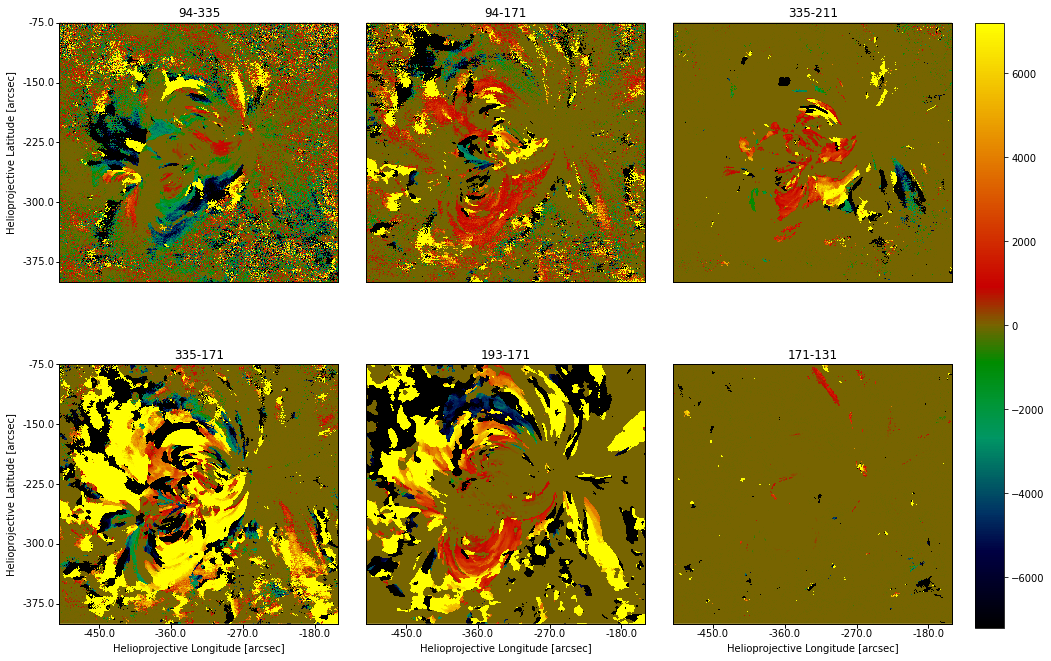

In [9]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = timelag_maps['{}-{}'.format(*cp)]
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

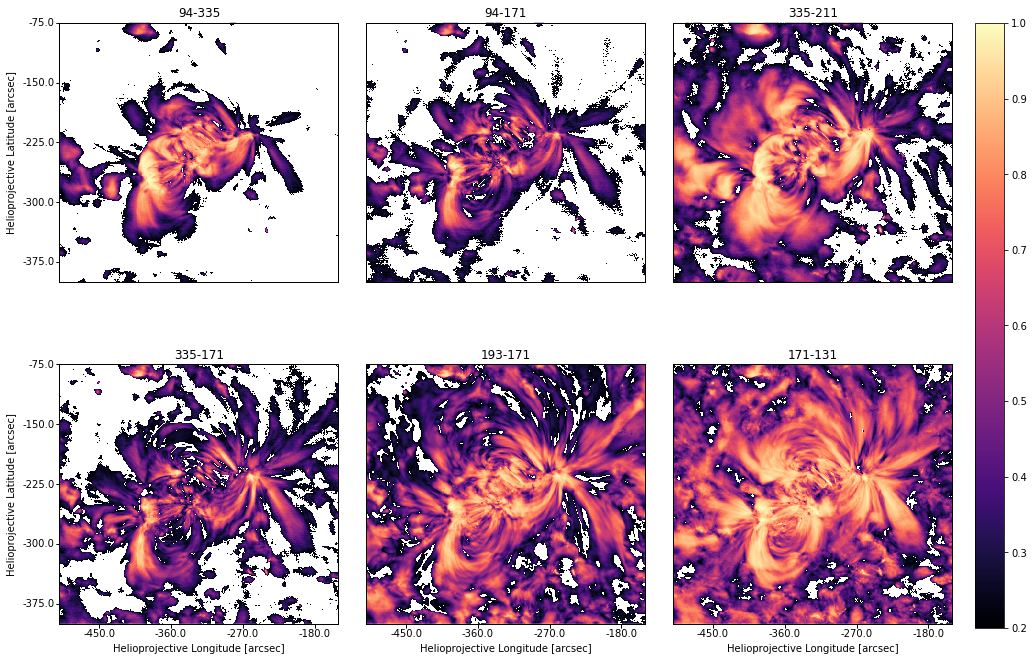

In [10]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    data = m.data / m.data.max()
    data = np.where(data < 0.2, np.nan, data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0.2, vmax=1,cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

Text(0.5,0,'timelag [s]')

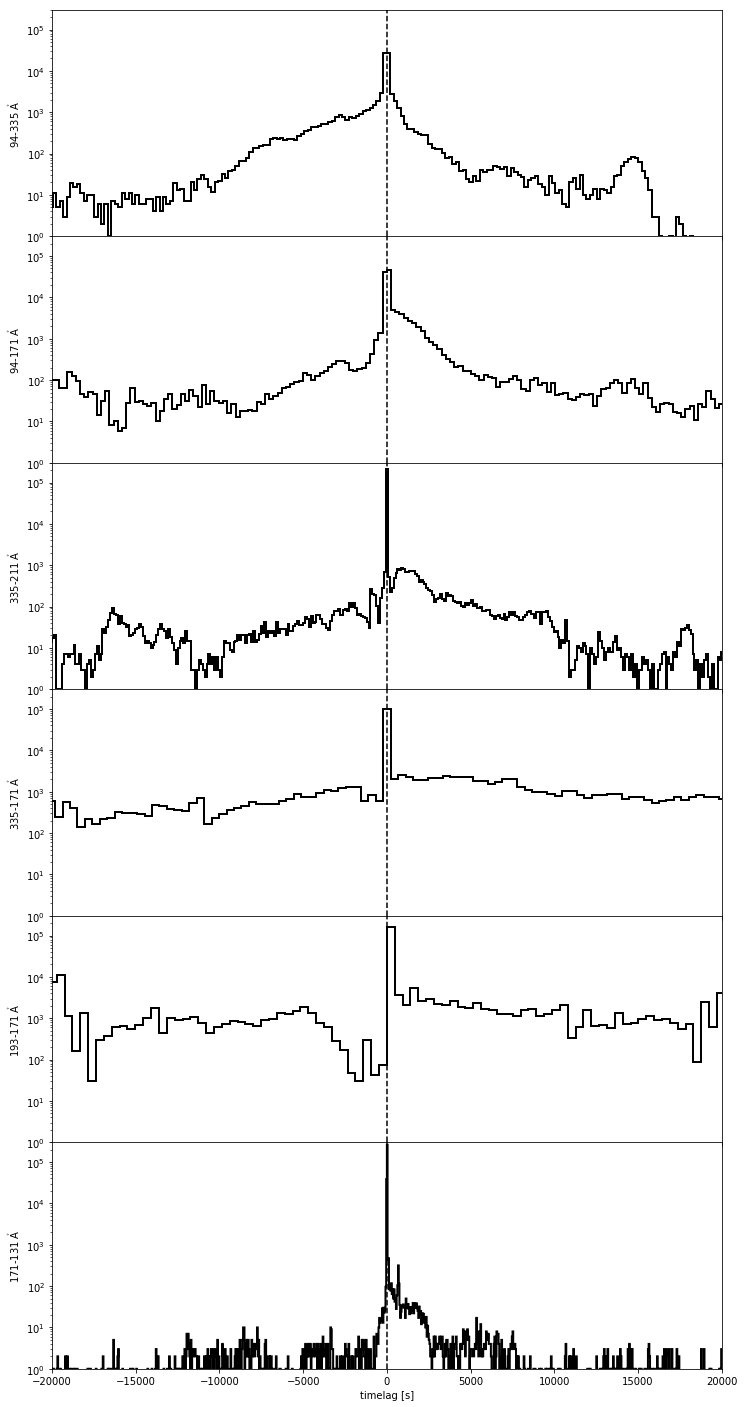

In [11]:
params = {'log':True,'bins':'scott','histtype':'step','lw':2,}
fig,axes = plt.subplots(len(channel_pairs),1,figsize=(12,25),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0)
for i,(p,ax) in enumerate(zip(channel_pairs,axes.flatten())):
    # Timelags
    tmp = timelag_maps['{}-{}'.format(*p)]
    data = tmp.data.flatten()
    # Correlations
    tmp = correlation_maps['{}-{}'.format(*p)]
    data_cor = tmp.data.flatten()
    data_cor /= data_cor.max()
    # plot
    ax.hist(data[np.where(data_cor >= 0.2)], **params,color=f'k',ls='-')
    ax.axvline(x=0,ls='--',color='k')
    ax.set_ylabel(r'{}-{} $\mathrm{{\mathring{{A}}}}$'.format(*p))
axes[0].set_xlim(
    #-(6*u.hr).to(u.s).value, (6*u.hr).to(u.s).value
    -2e4,2e4
)
axes[0].set_ylim(1,3e5)
axes[-1].set_xlabel(r'timelag [s]')